In [1]:
import torch
import torch.nn as nn

import tensorflow as tf

import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm
import numpy as np
import cv2
import pandas as pd

import random

from sklearn.linear_model import LinearRegression

from NeuralGraph import NeuralGraph

c:\Users\bunna\AppData\Local\Programs\Python\Python39\lib\site-packages\requests\__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.16) or chardet (5.1.0)/charset_normalizer (2.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


In [2]:
np.random.seed(42)
random.seed(42)
torch.manual_seed(42)

In [3]:
def split_dataset(x, y, valid_split=.2, test_split=.2):
    classes = np.unique(y)
    train_valid_split = round(len(classes)*(1-(valid_split+test_split)))
    valid_test_split = round(len(classes)*(1-test_split))

    train_classes = set(classes[:train_valid_split])
    valid_classes = set(classes[train_valid_split:valid_test_split])
    test_classes = set(classes[valid_test_split:])

    train = {i:[] for i in train_classes}
    valid = {i:[] for i in valid_classes}
    test = {i:[] for i in test_classes}

    for data, class_ in zip(x, y):
        if class_ in train_classes:
            train[class_].append(data)
        
        elif class_ in valid_classes:
            valid[class_].append(data)

        else:
            test[class_].append(data)

    for class_ in train_classes:
        train[class_] = np.stack(train[class_])

    for class_ in valid_classes:
        valid[class_] = np.stack(valid[class_])

    for class_ in test_classes:
        test[class_] = np.stack(test[class_])

    return train, valid, test

In [4]:
SIZE = 7

(x, y), (_, _) = tf.keras.datasets.mnist.load_data()
x = np.stack([cv2.resize(img/255.0, dsize=[SIZE, SIZE]) for img in x]).reshape(-1, SIZE**2)

_, mnist_valid, mnist_test = split_dataset(x, y, valid_split=.5, test_split=.5)

(x, y), (_, _) = tf.keras.datasets.fashion_mnist.load_data()
x = np.stack([cv2.resize(img/255.0, dsize=[SIZE, SIZE]) for img in x]).reshape(-1, SIZE**2)

_, fashion_valid, fashion_test = split_dataset(x, y, valid_split=.5, test_split=.5)

emnist = pd.read_csv("emnist-letters-train.csv").values
x, y = emnist[:, 1:], emnist[:, 0]
x = np.stack([cv2.resize(cv2.flip(cv2.rotate(img.reshape(28, 28)/255.0, cv2.ROTATE_90_CLOCKWISE), 1), dsize=[SIZE, SIZE]) for img in x]).reshape(-1, SIZE**2)

emnist_train, emnist_valid, emnist_test = split_dataset(x, y)

In [5]:
train = [emnist_train]
valid = [mnist_valid, fashion_valid, emnist_valid]

dict_keys([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16])


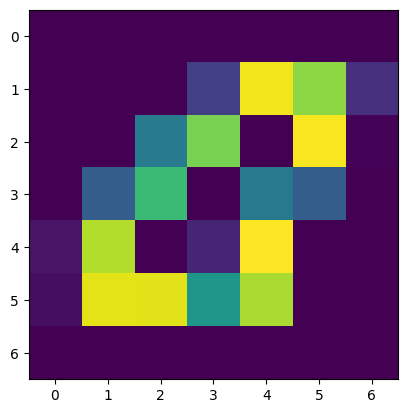

dict_keys([0, 1, 2, 3, 4])


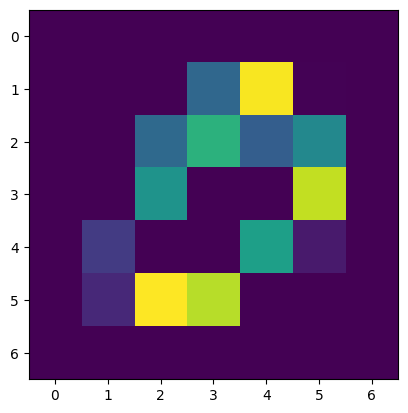

dict_keys([5, 6, 7, 8, 9])


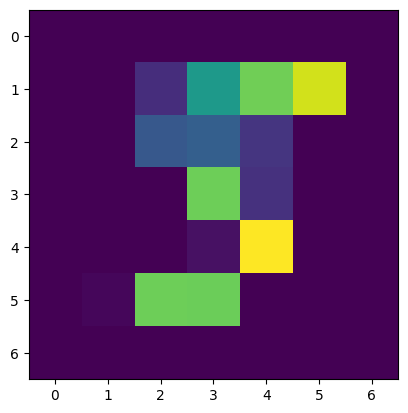

dict_keys([5, 6, 7, 8, 9])


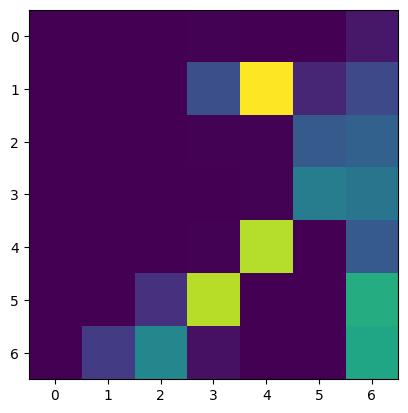

dict_keys([22, 23, 24, 25, 26])


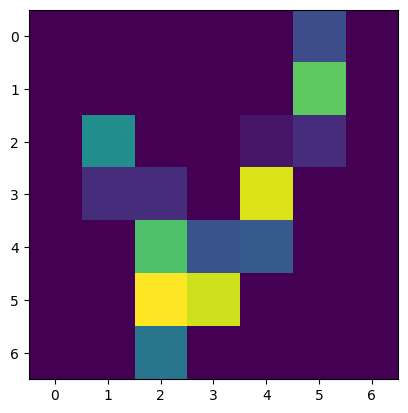

In [6]:
print(train[0].keys())
plt.imshow(train[0][list(train[0].keys())[0]][0].reshape(SIZE, SIZE))
plt.show()

print(valid[0].keys())
plt.imshow(valid[0][list(valid[0].keys())[0]][0].reshape(SIZE, SIZE))
plt.show()

print(mnist_test.keys())
plt.imshow(mnist_test[list(mnist_test.keys())[0]][0].reshape(SIZE, SIZE))
plt.show()

print(fashion_test.keys())
plt.imshow(fashion_test[list(fashion_test.keys())[0]][0].reshape(SIZE, SIZE))
plt.show()

print(emnist_test.keys())
plt.imshow(emnist_test[list(emnist_test.keys())[0]][0].reshape(SIZE, SIZE))
plt.show()

In [7]:
BATCH_SIZE = 16
TIME = 1
DT = .2

n_classes = 2
device = "cuda" if torch.cuda.is_available() else "cpu"

shape = [SIZE**2, n_classes]
n_nodes = sum(shape)
connections = [(sum(shape[:i])+x, sum(shape[:i+1])+y) for i in range(len(shape)-1) for x in range(shape[i]) for y in range(shape[i+1])]

print(len(connections))

graph = NeuralGraph(n_nodes, SIZE**2, n_classes, connections,
    ch_n=8, ch_e=8, value_init="random", init_value_std=.05,
    aggregation="mean", use_label=True, clamp_mode="soft", max_value=1e5, 
    device=device)

log = []

98


In [8]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(graph.parameters(), lr=1e-3)

### Memorize Task
##### Repeat input/output pairs in order they're given

In [41]:
STEPS = 3_000
START_EXAMPLES = 5
END_EXAMPLES = 50
log = []

In [42]:
examples = START_EXAMPLES

bar = tqdm(range(STEPS))
for _ in bar:
    x_train = torch.rand(BATCH_SIZE, examples, SIZE**2, device=device)
    y_train = torch.randint(n_classes, size=(BATCH_SIZE, examples), device=device)

    graph.init_vals(nodes=True, edges=True, batch_size=BATCH_SIZE)
    graph.detach_vals()
    optimizer.zero_grad()

    y_input = nn.functional.one_hot(y_train, n_classes).float()

    graph.learn(x_train, y_input, time=TIME, dt=DT, apply_once=True, reset_nodes=True)
    pred = graph.predict(x_train, time=TIME, dt=DT, apply_once=True, reset_nodes=True)

    acc = (pred.argmax(2) == y_train).float().mean()

    task_loss = criterion(pred, y_input)
    overflow = graph.overflow()

    loss = task_loss + overflow
    loss.backward()

    torch.nn.utils.clip_grad_norm_(graph.parameters(), 1.0)
    optimizer.step()

    if np.mean([e["acc"] for e in log[-10:]]) > .99 and examples < END_EXAMPLES:
        examples += 1

    entry = {'loss': task_loss.item(), 'acc': acc.item(), "overflow": overflow.item(), "examples":examples}
    log.append(entry)
    bar.set_postfix({"loss":np.mean([e["loss"] for e in log[-10:]]), "acc":np.mean([e["acc"] for e in log[-10:]]), "overflow":entry["overflow"], "examples":examples})

100%|██████████| 3000/3000 [1:17:26<00:00,  1.55s/it, loss=0.00462, acc=0.995, overflow=2.77e-5, examples=50] 


In [46]:
# fig, ax1 = plt.subplots()

# ax1.set_xlabel('steps')
# ax1.set_ylabel('Loss / Accuracy')
# ax1.plot([e['loss'] for e in log], label="loss")
# ax1.plot([e['acc'] for e in log], label="accuracy")

# # ax1.tick_params(axis='y', labelcolor=color)

# ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

# ax2.set_ylabel('examples')  # we already handled the x-label with ax1
# ax2.plot([e['examples'] for e in log], label="examples")
# # ax2.tick_params(axis='y', labelcolor=color)

# fig.tight_layout()  # otherwise the right y-label is slightly clipped
# plt.show()

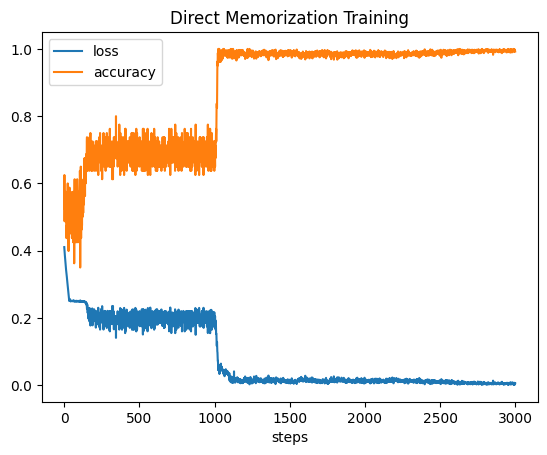

In [47]:
plt.title("Direct Memorization Training")

plt.plot([e['loss'] for e in log], label="loss")
plt.plot([e['acc'] for e in log], label="accuracy")
# plt.plot([e['examples'] for e in log], label="examples")
plt.legend()
plt.xlabel("steps")

# plt.savefig("direct_memorize.png", dpi=500)
plt.show()

graph.save("models/long_direct_memorize.pt")

### Now train again with hidden layer

In [17]:
shape = [SIZE**2, 8, n_classes]
n_nodes = sum(shape)
connections = [(sum(shape[:i])+x, sum(shape[:i+1])+y) for i in range(len(shape)-1) for x in range(shape[i]) for y in range(shape[i+1])]

print(len(connections))

graph = NeuralGraph(n_nodes, SIZE**2, n_classes, connections,
    ch_n=8, ch_e=8, value_init="random", init_value_std=.05, 
    aggregation="mean", use_label=True, clamp_mode="soft", max_value=1e5,
    device=device)

log = []

408


TypeError: __init__() got an unexpected keyword argument 'checkpoint_every'

In [10]:
graph.load("models/long_direct_memorize.pt")

In [61]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(graph.parameters(), lr=1e-4)

STEPS = 10_000
START_EXAMPLES = 5
END_EXAMPLES = 50
log = []

In [62]:
examples = START_EXAMPLES

bar = tqdm(range(STEPS))
for _ in bar:
    x_train = torch.rand(BATCH_SIZE, examples, SIZE**2, device=device)
    y_train = torch.randint(n_classes, size=(BATCH_SIZE, examples), device=device)

    graph.init_vals(nodes=True, edges=True, batch_size=BATCH_SIZE)
    graph.detach_vals()
    optimizer.zero_grad()

    y_input = nn.functional.one_hot(y_train, n_classes).float()

    graph.learn(x_train, y_input, time=TIME, dt=DT, apply_once=True, reset_nodes=True)
    pred = graph.predict(x_train, time=TIME, dt=DT, apply_once=True, reset_nodes=True)

    acc = (pred.argmax(2) == y_train).float().mean()

    task_loss = criterion(pred, y_input)
    overflow = graph.overflow()

    loss = task_loss + overflow
    loss.backward()

    torch.nn.utils.clip_grad_norm_(graph.parameters(), 1.0)
    optimizer.step()

    if np.mean([e["acc"] for e in log[-10:]]) > .99 and examples < END_EXAMPLES:
        examples += 1

    entry = {'loss': task_loss.item(), 'acc': acc.item(), "overflow": overflow.item(), "examples":examples}
    log.append(entry)
    bar.set_postfix({"loss":np.mean([e["loss"] for e in log[-10:]]), "acc":np.mean([e["acc"] for e in log[-10:]]), "overflow":entry["overflow"], "examples":examples})

  0%|          | 0/10000 [00:00<?, ?it/s]C:\Users\bunna\AppData\Roaming\Python\Python39\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\bunna\AppData\Roaming\Python\Python39\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
 68%|██████▊   | 6777/10000 [3:43:03<1:46:05,  1.97s/it, loss=0.0111, acc=0.987, overflow=1.78e-5, examples=50]  


KeyboardInterrupt: 

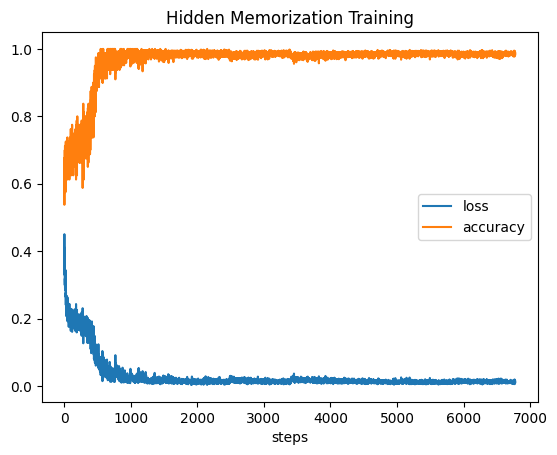

In [63]:
plt.title("Hidden Memorization Training")

plt.plot([e['loss'] for e in log], label="loss")
plt.plot([e['acc'] for e in log], label="accuracy")
plt.legend()
plt.xlabel("steps")

# plt.savefig("hidden_memorize.png", dpi=500)
plt.show()

In [64]:
graph.save("models/long_memorize.pt")

### Generalization Task
##### Given input/output pairs from a specific task, given output from unseen input data from that task

In [8]:
shape = [SIZE**2, 8, n_classes]
n_nodes = sum(shape)
connections = [(sum(shape[:i])+x, sum(shape[:i+1])+y) for i in range(len(shape)-1) for x in range(shape[i]) for y in range(shape[i+1])]

print(len(connections))

graph = NeuralGraph(n_nodes, SIZE**2, n_classes, connections,
    ch_n=8, ch_e=8, value_init="random", init_value_std=.05, 
    aggregation="mean", use_label=True, clamp_mode="soft", max_value=1e5, use_checkpoints=True, checkpoint_every=2,
    device=device)

log = []

408


In [9]:
# graph.load("models/long_memorize.pt")
graph.load("models/long_generalize.pt")

In [10]:
EXAMPLES = 50
# TEST_EXAMPLES = 10
# Reset optimizer
optimizer = torch.optim.Adam(graph.parameters(), lr=1e-5)
criterion = nn.MSELoss()

STEPS = 100_000

log = []

In [11]:
def shuffle_along_axis(a, axis):
    idx = np.random.rand(*a.shape).argsort(axis=axis)
    return np.take_along_axis(a,idx,axis=axis)

def get_batch_data(dataset=train, batch_size=BATCH_SIZE, train_examples=EXAMPLES, test_examples=EXAMPLES):
    if type(dataset) != list:
        dataset = [dataset]
    set_ = np.random.randint(len(dataset), size=(batch_size))

    classes = np.stack([np.random.choice(list(dataset[i].keys()), size=(n_classes), replace=False) for i in set_])
    
    # This gets completely random examples
    # y_train = np.random.randint(n_classes, size=(batch_size, train_examples))
    # y_test = np.random.randint(n_classes, size=(batch_size, TEST_EXAMPLES))

    # This gets balanced random examples
    
    y_train = np.repeat(np.expand_dims(np.round(np.linspace(0, n_classes-1, train_examples)), axis=0), batch_size, axis=0).astype(np.int32)
    y_test = np.repeat(np.expand_dims(np.round(np.linspace(0, n_classes-1, test_examples)), axis=0), batch_size, axis=0).astype(np.int32)

    y_train = shuffle_along_axis(y_train, axis=1)
    y_test = shuffle_along_axis(y_test, axis=1)


    x_train = []
    for batch_classes, y, i in zip(classes, y_train, set_):
        x_train.append([])
        for class_ in batch_classes[y]:
            x_train[-1].append(random.choice(dataset[i][class_]))
        x_train[-1] = np.stack(x_train[-1])
    x_train = np.stack(x_train)

    x_test = []
    for batch_classes, y, i in zip(classes, y_test, set_):
        x_test.append([])
        for class_ in batch_classes[y]:
            x_test[-1].append(random.choice(dataset[i][class_]))
        x_test[-1] = np.stack(x_test[-1])
    x_test = np.stack(x_test)
    
    return torch.Tensor(x_train).to(device), torch.Tensor(y_train).long().to(device), torch.Tensor(x_test).to(device), torch.Tensor(y_test).long().to(device), classes

In [12]:
START_EXAMPLES = 150
END_EXAMPLES = 150

examples = START_EXAMPLES

In [13]:
TEST_START = 2

bar = tqdm(range(1, STEPS+1))
for step in bar:

    # Train step
    x, y, _, _, classes = get_batch_data(dataset=train, train_examples=examples, test_examples=1)
    y_oh = nn.functional.one_hot(y, n_classes).float()

    graph.init_vals(nodes=True, edges=True, batch_size=BATCH_SIZE)
    graph.detach_vals()
    optimizer.zero_grad()

    
    # Instead of having entirely separate train/test, we will say given 1 what is 2, given 1 and 2 what is 3, etc.
    y_pred = []
    for i in range(examples):
        graph.reset_vals(nodes=True, edges=False)

        y_pred_ = graph.forward(x[:, i], apply_once=True, time=TIME, dt=DT)
        graph.backward(x[:, i], y_oh[:, i], apply_once=True, time=TIME, dt=DT)

        y_pred.append(y_pred_)

    y_pred = torch.stack(y_pred, axis=1)


    acc = (y_pred.argmax(2)[:, TEST_START:] == y[:, TEST_START:]).float().mean()

    task_loss = criterion(y_pred[:, TEST_START:], y_oh[:, TEST_START:])
    overflow = graph.overflow()

    loss = task_loss + overflow
    loss.backward()

    torch.nn.utils.clip_grad_norm_(graph.parameters(), 1.0)
    optimizer.step()

    # Valid step
    with torch.no_grad():
        x, y, _, _, classes = get_batch_data(dataset=valid, train_examples=examples, test_examples=1)
        y_oh = nn.functional.one_hot(y, n_classes).float()

        graph.init_vals(nodes=True, edges=True, batch_size=BATCH_SIZE)

    
        # Instead of having entirely separate train/test, we will say given 1 what is 2, given 1 and 2 what is 3, etc.
        y_pred = []
        for i in range(examples):
            graph.reset_vals(nodes=True, edges=False)

            y_pred_ = graph.forward(x[:, i], apply_once=True, time=TIME, dt=DT)
            graph.backward(x[:, i], y_oh[:, i], apply_once=True, time=TIME, dt=DT)

            y_pred.append(y_pred_)

        y_pred = torch.stack(y_pred, axis=1)

        valid_acc = (y_pred.argmax(2)[:, TEST_START:] == y[:, TEST_START:]).float().mean()
        valid_loss = criterion(y_pred[:, TEST_START:], y_oh[:, TEST_START:])

    # Save
    if step % 2000 == 0 and step != 0:
        graph.save(f"models/long_generalize_{step}.pt")

    # Increase num examples
    if step % 300 == 0 and examples < END_EXAMPLES:
        examples += 1

    entry = {'valid_loss':valid_loss.item(), 'valid_acc':valid_acc.item(), 'loss': task_loss.item(), 'acc': acc.item(), "overflow": overflow.item()}
    log.append(entry)
    bar.set_postfix({"valid_loss":np.mean([e["valid_loss"] for e in log[-10:]]), "valid_acc":np.mean([e["valid_acc"] for e in log[-10:]]), "loss":np.mean([e["loss"] for e in log[-10:]]), "acc":np.mean([e["acc"] for e in log[-10:]]), "overflow":entry["overflow"], "examples":examples})

  0%|          | 0/100000 [00:00<?, ?it/s]

  2%|▏         | 1939/100000 [4:39:44<235:47:22,  8.66s/it, valid_loss=0.0956, valid_acc=0.873, loss=0.0755, acc=0.899, overflow=0.00473, examples=150] 


KeyboardInterrupt: 

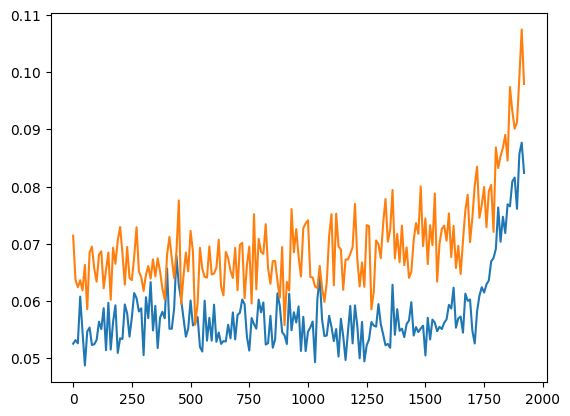

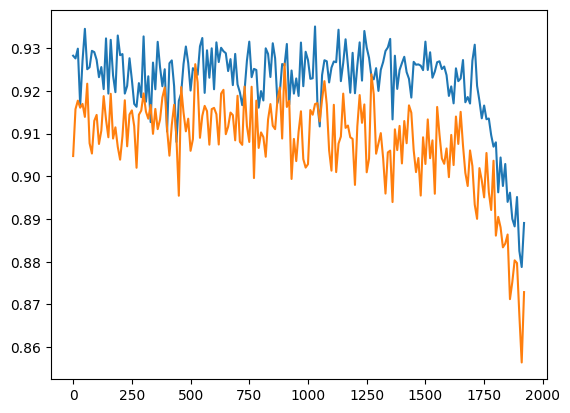

In [14]:
losses = [e["loss"] for e in log]
valid_losses = [e["valid_loss"] for e in log]

accs = [e["acc"] for e in log]
valid_accs = [e["valid_acc"] for e in log]

window = 10

plt.plot(range(0, len(losses)-window, window), [np.mean(losses[i:i+window]) for i in range(0, len(losses)-window, window)])
plt.plot(range(0, len(losses)-window, window), [np.mean(valid_losses[i:i+window]) for i in range(0, len(valid_losses)-window, window)])
plt.show()

plt.plot(range(0, len(losses)-window, window), [np.mean(accs[i:i+window]) for i in range(0, len(accs)-window, window)])
plt.plot(range(0, len(losses)-window, window), [np.mean(valid_accs[i:i+window]) for i in range(0, len(valid_accs)-window, window)])
plt.show()

In [15]:
graph.save("models/long_generalize.pt")

In [15]:
# graph.load("models/long_generalize.pt")

### Evaluate on Train digits, Test digits, Fashion test

In [23]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()

        self.main = nn.Sequential(
            nn.Linear(SIZE**2, 16),
            nn.ReLU(),
            nn.Linear(16, 16),
            nn.ReLU(),
            nn.Linear(16, n_classes),
            nn.Softmax(1),
        )
    
    def forward(self, x):
        return self.main(x)

def fit(model, x_train, y_train, steps=3):
    optimizer = torch.optim.Adam(model.parameters(), lr=2e-3)
    for _ in range(steps):
        optimizer.zero_grad()
        y_hat = model(x_train)
        loss = criterion(y_hat, y_train)

        loss.backward()
        optimizer.step()

In [26]:
N = 1024

graph_result_accs = {}
graph_result_losses = {}

FFN_result_accs = {"emnist_test":[], "mnist_test":[], "fashion_test":[]}
FFN_result_losses = {"emnist_test":[], "mnist_test":[], "fashion_test":[]}

for data_name, dataset in {"emnist_test":emnist_test, "mnist_test":mnist_test, "fashion_test":fashion_test}.items():

    with torch.no_grad():
        x, y, _, _, classes = get_batch_data(dataset=dataset, train_examples=examples, test_examples=1, batch_size=N)
        y_oh = nn.functional.one_hot(y, n_classes).float()

        graph.init_vals(nodes=True, edges=True, batch_size=N)

        # Instead of having entirely separate train/test, we will say given 1 what is 2, given 1 and 2 what is 3, etc.
        y_pred = []
        for i in tqdm(range(examples)):
            graph.reset_vals(nodes=True, edges=False)

            y_pred_ = graph.forward(x[:, i], apply_once=True, time=TIME, dt=DT)
            graph.backward(x[:, i], y_oh[:, i], apply_once=True, time=TIME, dt=DT)

            y_pred.append(y_pred_)

        y_pred = torch.stack(y_pred, axis=1)

        test_accs = (y_pred.argmax(2)[:, TEST_START:] == y[:, TEST_START:]).float().mean(0)
        test_losses = torch.square(y_pred[:, TEST_START:] - y_oh[:, TEST_START:]).mean(0).mean(-1)

        graph_result_accs[data_name] = test_accs
        graph_result_losses[data_name] = test_losses


    for k in tqdm(range(2, examples-1)):
        accs = []
        losses = []
        for i in range(N):
            model = Model().to(device)

            fit(model, x[i, :k], y_oh[i, :k], steps=50)
            pred = model(x[i, k:k+1])
            model_acc = (pred.argmax(1) == y[i, k:k+1]).float().mean()
            model_loss = criterion(pred, y_oh[i, k:k+1])
            accs.append(model_acc.item())
            losses.append(model_loss.item())
    
        FFN_result_accs[data_name].append(np.mean(accs))
        FFN_result_losses[data_name].append(np.mean(losses))

100%|██████████| 147/147 [2:49:51<00:00, 69.33s/it] 


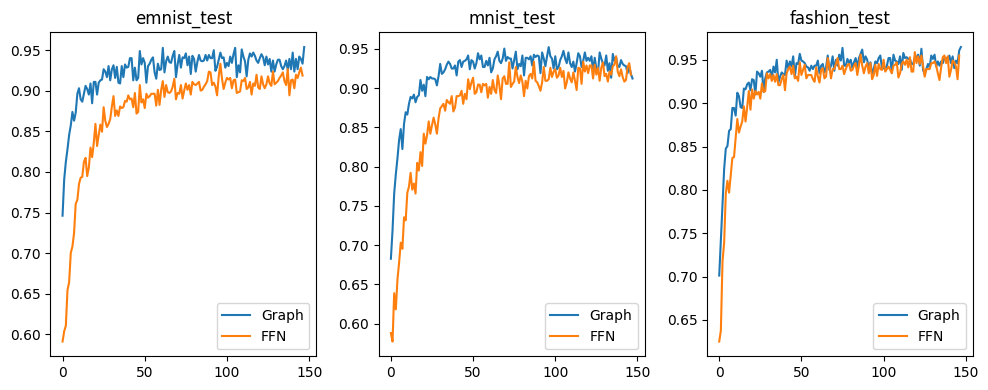

In [27]:
plt.figure(figsize=(10, 4))

for i, data_name in enumerate(["emnist_test", "mnist_test", "fashion_test"]):
    plt.subplot(1, 3, i+1)
    plt.title(data_name)
    plt.plot(graph_result_accs[data_name].cpu(), label="Graph")
    plt.plot(FFN_result_accs[data_name], label="FFN")
    plt.legend()

plt.tight_layout()
plt.show()

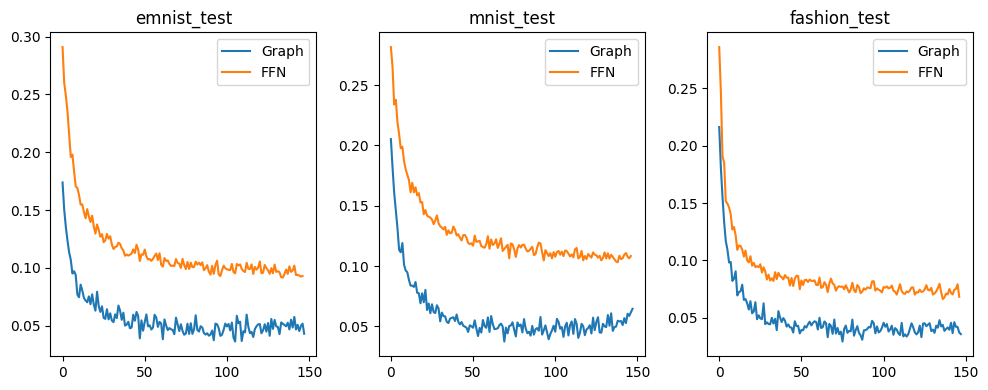

In [28]:
plt.figure(figsize=(10, 4))

for i, data_name in enumerate(["emnist_test", "mnist_test", "fashion_test"]):
    plt.subplot(1, 3, i+1)
    plt.title(data_name)
    plt.plot(graph_result_losses[data_name].cpu(), label="Graph")
    plt.plot(FFN_result_losses[data_name], label="FFN")
    plt.legend()

plt.tight_layout()
plt.show()

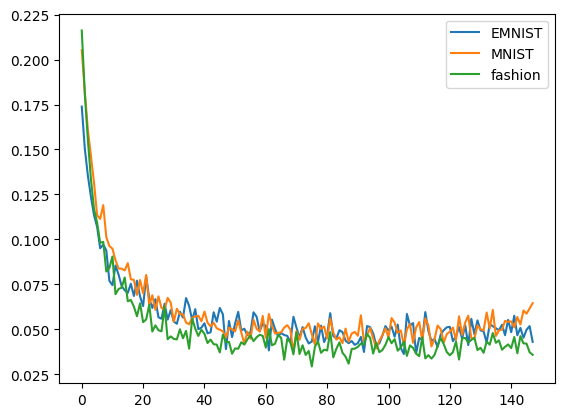

In [29]:
plt.plot(graph_result_losses["emnist_test"].cpu(), label="EMNIST")
plt.plot(graph_result_losses["mnist_test"].cpu(), label="MNIST")
plt.plot(graph_result_losses["fashion_test"].cpu(), label="fashion")
# plt.plot(np.arange(50), .25*np.log(np.arange(50)))
# plt.plot([50, 50], [.5, 1])
plt.legend()
plt.show()

[-0.36431834  0.98463145]
[0.24138019 0.01721767]


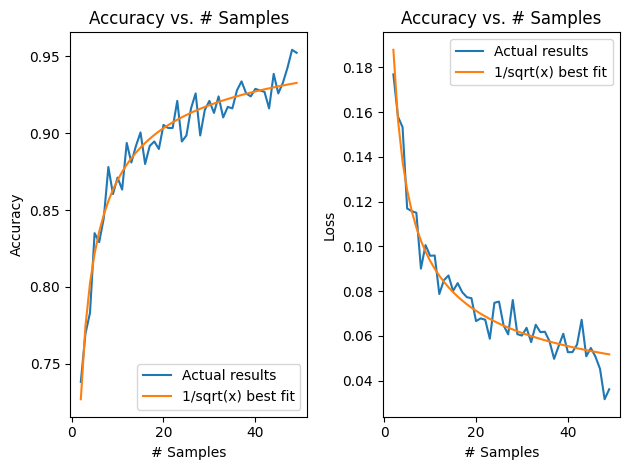

[-0.7822891  1.1685121]
[0.33482064 0.00718198]


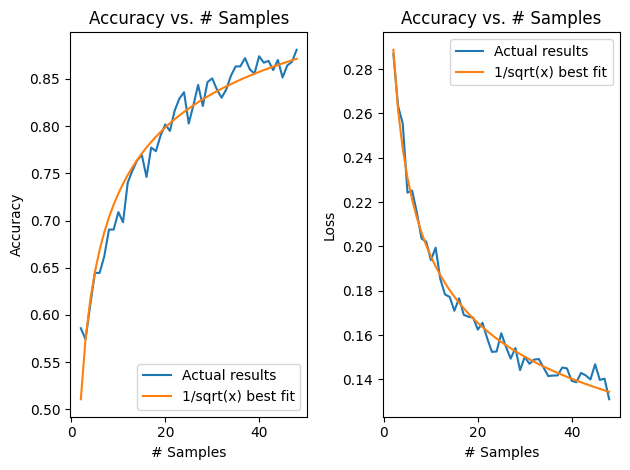

In [210]:
# x = 1/np.arange(2, 2+results["emnist_test"].cpu().numpy().shape[0]).reshape(-1, 1)
# x = np.concatenate([x, np.ones_like(x)], axis=1)

# y = results["emnist_test"].cpu().numpy().reshape(-1, 1)


# w = np.linalg.inv(x.T @ x) @ x.T @ y

# print(w)

# plt.plot(results["emnist_test"].cpu())
# plt.plot(np.arange(2, 2+results["emnist_test"].cpu().numpy().shape[0]), (x @ w).flatten())
# plt.show()



x = 1/np.sqrt(np.arange(2, 2+graph_result_accs["emnist_test"].cpu().numpy().shape[0])).reshape(-1, 1)
# x = 1/np.arange(2, 2+graph_result_accs["emnist_test"].cpu().numpy().shape[0]).reshape(-1, 1)
x = np.concatenate([x, np.ones_like(x)], axis=1)

y = graph_result_accs["emnist_test"].cpu().numpy().reshape(-1, 1)

w1 = np.linalg.inv(x.T @ x) @ x.T @ y

print(w1.flatten())

plt.subplot(1, 2, 1)

plt.title("Accuracy vs. # Samples")
plt.xlabel("# Samples")
plt.ylabel("Accuracy")
plt.plot(np.arange(2, 2+graph_result_accs["emnist_test"].cpu().numpy().shape[0]), graph_result_accs["emnist_test"].cpu(), label="Actual results")
plt.plot(np.arange(2, 2+graph_result_accs["emnist_test"].cpu().numpy().shape[0]), (x @ w1).flatten(), label="1/sqrt(x) best fit")
plt.legend()



x = 1/np.sqrt(np.arange(2, 2+graph_result_losses["emnist_test"].cpu().numpy().shape[0])).reshape(-1, 1)
# x = 1/np.arange(2, 2+graph_result_losses["emnist_test"].cpu().numpy().shape[0]).reshape(-1, 1)
x = np.concatenate([x, np.ones_like(x)], axis=1)

y = graph_result_losses["emnist_test"].cpu().numpy().reshape(-1, 1)

w2 = np.linalg.inv(x.T @ x) @ x.T @ y

print(w2.flatten())

plt.subplot(1, 2, 2)

plt.title("Accuracy vs. # Samples")
plt.xlabel("# Samples")
plt.ylabel("Loss")
plt.plot(np.arange(2, 2+graph_result_losses["emnist_test"].cpu().numpy().shape[0]), graph_result_losses["emnist_test"].cpu(), label="Actual results")
plt.plot(np.arange(2, 2+graph_result_losses["emnist_test"].cpu().numpy().shape[0]), (x @ w2).flatten(), label="1/sqrt(x) best fit")
plt.legend()
plt.tight_layout()
plt.show()




x = np.power(np.arange(2, 2+len(FFN_result_accs["emnist_test"])), -.25).reshape(-1, 1)
# x = 1/np.arange(2, 2+len(FFN_result_accs["emnist_test"])).reshape(-1, 1)
x = np.concatenate([x, np.ones_like(x)], axis=1)

y = np.array(FFN_result_accs["emnist_test"]).reshape(-1, 1)


w3 = np.linalg.inv(x.T @ x) @ x.T @ y

print(w3.flatten())

plt.subplot(1, 2, 1)

plt.title("Accuracy vs. # Samples")
plt.xlabel("# Samples")
plt.ylabel("Accuracy")
plt.plot(np.arange(2, 2+len(FFN_result_accs["emnist_test"])), FFN_result_accs["emnist_test"], label="Actual results")
plt.plot(np.arange(2, 2+len(FFN_result_accs["emnist_test"])), (x @ w3).flatten(), label="1/sqrt(x) best fit")
plt.legend()



x = np.power(np.arange(2, 2+len(FFN_result_accs["emnist_test"])), -.25).reshape(-1, 1)
# x = 1/np.arange(2, 2+len(FFN_result_accs["emnist_test"])).reshape(-1, 1)
x = np.concatenate([x, np.ones_like(x)], axis=1)

y = np.array(FFN_result_losses["emnist_test"]).reshape(-1, 1)


w4 = np.linalg.inv(x.T @ x) @ x.T @ y

print(w4.flatten())

plt.subplot(1, 2, 2)

plt.title("Accuracy vs. # Samples")
plt.xlabel("# Samples")
plt.ylabel("Loss")
plt.plot(np.arange(2, 2+len(FFN_result_accs["emnist_test"])), FFN_result_losses["emnist_test"], label="Actual results")
plt.plot(np.arange(2, 2+len(FFN_result_accs["emnist_test"])), (x @ w4).flatten(), label="1/sqrt(x) best fit")
plt.legend()
plt.tight_layout()
plt.show()

[[-0.25934795]
 [-1.86316724]]
[[-0.23534751]
 [-1.23203073]]
[[-0.28350365]
 [-1.72463625]]
[[-0.21399777]
 [-1.22037377]]
[[-0.32162304]
 [-1.76326304]]
[[-0.24172074]
 [-1.49641727]]


<Figure size 640x480 with 0 Axes>

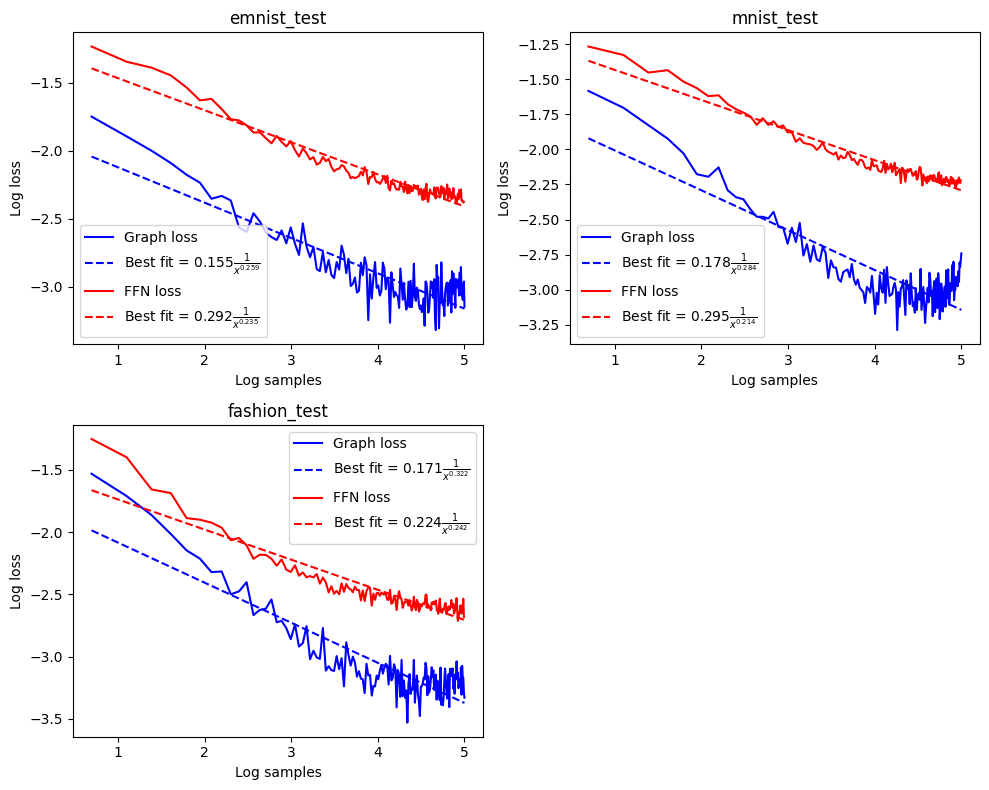

In [40]:
# dataset = "emnist_test"
plt.suptitle("Log Loss vs. Log samples")
plt.figure(figsize=(10, 8))

for i, dataset in enumerate(["emnist_test", "mnist_test", "fashion_test"]):

    plt.subplot(2, 2, i+1)

    log_x = np.log(np.arange(2, 2+graph_result_losses[dataset].cpu().numpy().shape[0]))
    log_y = np.log(graph_result_losses[dataset].cpu().numpy())

    log_x_ = np.stack([log_x, np.ones_like(log_x)], axis=-1)

    log_w = np.linalg.inv(log_x_.T @ log_x_) @ log_x_.T @ log_y.reshape(-1, 1)

    print(log_w)

    latex_str = r'Best fit = $ %.3f \frac{1}{x^{%.3f}}$' % (np.exp(log_w[1, 0]), -log_w[0, 0])

    plt.title(dataset)
    plt.xlabel("Log samples")
    plt.ylabel("Log loss")


    plt.plot(log_x, log_y, label="Graph loss", color="blue")
    plt.plot(log_x, (log_x_ @ log_w), label=latex_str, color="blue", linestyle="--")
    # plt.show()




    log_x = np.log(np.arange(2, 2+len(FFN_result_losses[dataset])))
    log_y = np.log(np.array(FFN_result_losses[dataset]))

    log_x_ = np.stack([log_x, np.ones_like(log_x)], axis=-1)

    log_w = np.linalg.inv(log_x_.T @ log_x_) @ log_x_.T @ log_y.reshape(-1, 1)

    print(log_w)

    latex_str = r'Best fit = $ %.3f \frac{1}{x^{%.3f}}$' % (np.exp(log_w[1, 0]), -log_w[0, 0])

    plt.plot(log_x, log_y, label="FFN loss", color="red")
    plt.plot(log_x, (log_x_ @ log_w), label=latex_str, color="red", linestyle="--")

    plt.legend()
    # plt.show()
plt.tight_layout()
plt.savefig("learning_rates.png", dpi=400)
plt.show()

In [ ]:
graph.load("models/long_direct_memorize.pt")

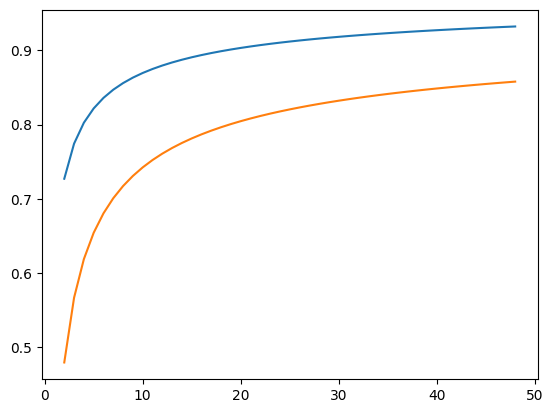

In [198]:
plt.plot(np.arange(2, 2+len(FFN_result_accs["emnist_test"])), (x @ w1).flatten())# , label="1/sqrt(x) best fit")
plt.plot(np.arange(2, 2+len(FFN_result_accs["emnist_test"])), (x @ w3).flatten())# , label="1/sqrt(x) best fit")
plt.show()

In [53]:
overall_accs = {}
overall_losses = {}

N = 2048

for data_name, dataset in {"emnist_test":emnist_test, "mnist_test":mnist_test, "fashion_test":fashion_test}.items():# ["valid"]:
    print(f"Data: {data_name}")

    accs = {"graph":[], "linreg":[], "ANN_50_steps":[], "ANN_10_steps":[], "ANN_1_steps":[]}
    losses = {"graph":[], "linreg":[], "ANN_50_steps":[], "ANN_10_steps":[], "ANN_1_steps":[]}

    x_train, y_train, x_test, y_test, classes = get_batch_data(dataset=dataset, batch_size=N)
    y_input = nn.functional.one_hot(y_train, n_classes).float()
    y_label = nn.functional.one_hot(y_test, n_classes).float()
    
    # Try graph
    with torch.no_grad():
        graph.init_vals(nodes=True, edges=True, batch_size=N)

        graph.learn(x_train, y_input, time=TIME, dt=DT, apply_once=True, reset_nodes=True)
        pred = graph.predict(x_test, time=TIME, dt=DT, apply_once=True, reset_nodes=True)

        graph_acc = (pred.argmax(2) == y_test).float().mean()
        graph_loss = criterion(pred, y_label)

        accs["graph"].append(graph_acc.item())
        losses["graph"].append(graph_loss.item())

    # Try linear regression and an ANN on each batch
    for x_train_b, y_train_b, x_test_b, y_test_b, y_input_b, y_label_b in tqdm(zip(x_train, y_train, x_test, y_test, y_input, y_label), total=N):
        model = LinearRegression()

        model.fit(x_train_b.cpu(), y_input_b.cpu())
        pred = torch.Tensor(model.predict(x_test_b.cpu())).to(device)

        linreg_acc = (pred.argmax(1) == y_test_b).float().mean()
        linreg_loss = criterion(pred, y_label_b)

        accs["linreg"].append(linreg_acc.item())
        losses["linreg"].append(linreg_loss.item())


        # Train model for 1, 10, 50 epochs and record acc / loss
        for steps in [1, 10, 50]:
            model = Model().to(device)

            fit(model, x_train_b, y_input_b, steps=steps)
            pred = model(x_test_b)

            model_acc = (pred.argmax(1) == y_test_b).float().mean()
            model_loss = criterion(pred, y_label_b)

            accs[f"ANN_{steps}_steps"].append(model_acc.item())
            losses[f"ANN_{steps}_steps"].append(model_loss.item())

    overall_accs[data_name] = {k:np.mean(v) for k, v in accs.items()}
    overall_losses[data_name] = {k:np.mean(v) for k, v in losses.items()}

Data: emnist_test


100%|██████████| 2048/2048 [02:47<00:00, 12.20it/s]


Data: mnist_test


100%|██████████| 2048/2048 [02:47<00:00, 12.24it/s]


Data: fashion_test


100%|██████████| 2048/2048 [02:43<00:00, 12.56it/s]


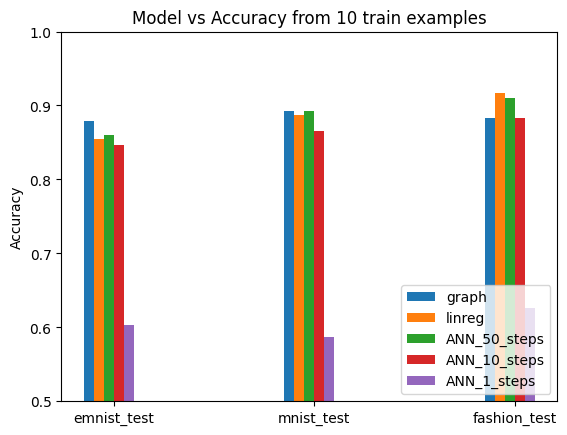

In [33]:
width=.05

plt.title("Model vs Accuracy from 10 train examples")

# plt.xticks(rotation='vertical')
plt.ylim(.5, 1)
plt.ylabel("Accuracy")

X = overall_accs.keys()
X_axis = np.arange(len(X))

plt.xticks(X_axis, X)

model_names = overall_accs[list(overall_accs.keys())[0]].keys()

for i, model_name in enumerate(model_names):
    accs = []
    for data_set in X:
        accs.append(overall_accs[data_set][model_name])
    plt.bar(X_axis + i*(width) - len(model_names)*(width/2), accs, width, label=model_name)
    

plt.legend(loc="lower right")
plt.savefig("results.png")
plt.show()

In [54]:
SIZE = 7

emnist = pd.read_csv("emnist-letters-train.csv").values

x, y = emnist[:, 1:], emnist[:, 0]
x = np.stack([cv2.resize(cv2.flip(cv2.rotate(img.reshape(28, 28)/255.0, cv2.ROTATE_90_CLOCKWISE), 1), dsize=[SIZE, SIZE]) for img in x]).reshape(-1, SIZE**2)

_, _, emnist49 = split_dataset(x, y)

SIZE = 28

x, y = emnist[:, 1:], emnist[:, 0]
x = np.stack([cv2.resize(cv2.flip(cv2.rotate(img.reshape(28, 28)/255.0, cv2.ROTATE_90_CLOCKWISE), 1), dsize=[SIZE, SIZE]) for img in x]).reshape(-1, SIZE**2)

_, _, emnist784 = split_dataset(x, y)

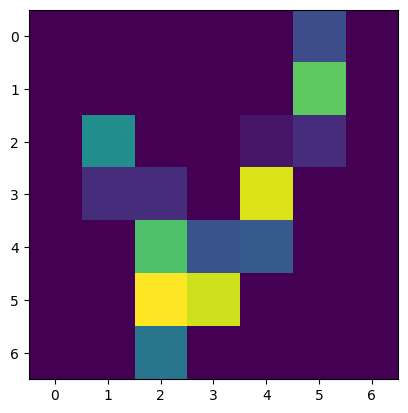

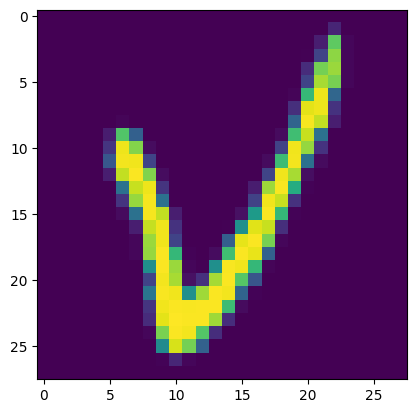

In [55]:
plt.imshow(emnist49[22][0].reshape(7, 7))
plt.show()
plt.imshow(emnist784[22][0].reshape(28, 28))
plt.show()

In [56]:
shape = [49, 8, n_classes]
n_nodes = sum(shape)
connections = [(sum(shape[:i])+x, sum(shape[:i+1])+y) for i in range(len(shape)-1) for x in range(shape[i]) for y in range(shape[i+1])]

print(len(connections))

graph49 = NeuralGraph(n_nodes, shape[0], shape[-1], connections,
    ch_n=8, ch_e=8, value_init="random", init_value_std=.05, 
    aggregation="mean", use_label=True, clamp_mode="soft", max_value=1e5, 
    device=device)

graph49.load("models/generalize_10000.pt")

shape = [784, 8, n_classes]
n_nodes = sum(shape)
connections = [(sum(shape[:i])+x, sum(shape[:i+1])+y) for i in range(len(shape)-1) for x in range(shape[i]) for y in range(shape[i+1])]

print(len(connections))

graph784 = NeuralGraph(n_nodes, shape[0], shape[-1], connections,
    ch_n=8, ch_e=8, value_init="random", init_value_std=.05, 
    aggregation="mean", use_label=True, clamp_mode="soft", max_value=1e5, 
    device=device)

graph784.load("models/generalize_10000.pt")

408
6288


In [57]:
N = 2048

accs = {}
losses = {}

for data_name, dataset, g in zip(["emnist 7x7", "emnist 14x14", "emnist 28x28"], [emnist49, emnist_test, emnist784], [graph49, graph, graph784]):
    print(f"Data: {data_name}")

    x_train, y_train, x_test, y_test, classes = get_batch_data(dataset=dataset, batch_size=N)
    y_input = nn.functional.one_hot(y_train, n_classes).float()
    y_label = nn.functional.one_hot(y_test, n_classes).float()
    
    # Try graph
    with torch.no_grad():
        g.init_vals(nodes=True, edges=True, batch_size=N)

        g.learn(x_train, y_input, time=TIME, dt=DT, apply_once=True, reset_nodes=True)
        pred = g.predict(x_test, time=TIME, dt=DT, apply_once=True, reset_nodes=True)

        acc = (pred.argmax(2) == y_test).float().mean()
        loss = criterion(pred, y_label)
        
        accs[data_name] = acc.item()
        losses[data_name] = loss.item()

Data: emnist 7x7
Data: emnist 14x14
Data: emnist 28x28


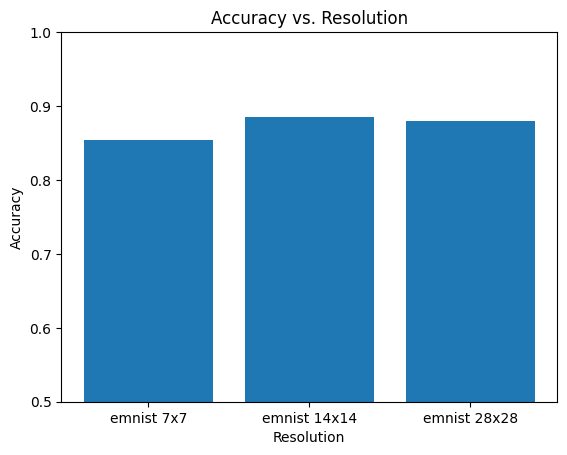

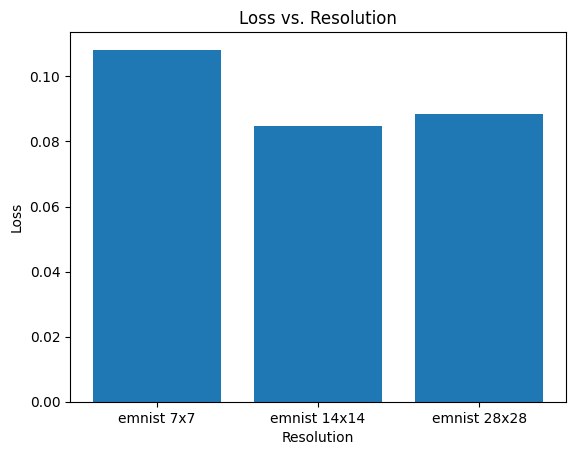

In [60]:
plt.title("Accuracy vs. Resolution")
plt.xlabel("Resolution")
plt.ylabel("Accuracy")
plt.bar(accs.keys(), accs.values())
plt.ylim(.5, 1)
plt.savefig("resolutions.png")
plt.show()


plt.title("Loss vs. Resolution")
plt.xlabel("Resolution")
plt.ylabel("Loss")
plt.bar(losses.keys(), losses.values())
plt.show()

In [61]:
shape = [14**2, 4, n_classes]
n_nodes = sum(shape)
connections = [(sum(shape[:i])+x, sum(shape[:i+1])+y) for i in range(len(shape)-1) for x in range(shape[i]) for y in range(shape[i+1])]

print(len(connections))

graph_h4 = NeuralGraph(n_nodes, shape[0], shape[-1], connections,
    ch_n=8, ch_e=8, value_init="random", init_value_std=.05, 
    aggregation="mean", use_label=True, clamp_mode="soft", max_value=1e5, 
    device=device)

graph_h4.load("models/generalize_10000.pt")

shape = [14**2, 16, n_classes]
n_nodes = sum(shape)
connections = [(sum(shape[:i])+x, sum(shape[:i+1])+y) for i in range(len(shape)-1) for x in range(shape[i]) for y in range(shape[i+1])]

print(len(connections))

graph_h16 = NeuralGraph(n_nodes, shape[0], shape[-1], connections,
    ch_n=8, ch_e=8, value_init="random", init_value_std=.05, 
    aggregation="mean", use_label=True, clamp_mode="soft", max_value=1e5, 
    device=device)

graph_h16.load("models/generalize_10000.pt")

792
3168


In [63]:
accs = {}
losses = {}

for name, g in zip(["4 hidden", "8 hidden", "16 hidden"], [graph_h4, graph, graph_h16]):
    print(f"Data: {name}")

    x_train, y_train, x_test, y_test, classes = get_batch_data(dataset=emnist_test, batch_size=N)
    y_input = nn.functional.one_hot(y_train, n_classes).float()
    y_label = nn.functional.one_hot(y_test, n_classes).float()
    
    # Try graph
    with torch.no_grad():
        g.init_vals(nodes=True, edges=True, batch_size=N)

        g.learn(x_train, y_input, time=TIME, dt=DT, apply_once=True, reset_nodes=True)
        pred = g.predict(x_test, time=TIME, dt=DT, apply_once=True, reset_nodes=True)

        acc = (pred.argmax(2) == y_test).float().mean()
        loss = criterion(pred, y_label)
        
        accs[name] = acc.item()
        losses[name] = loss.item()

Data: 4 hidden
Data: 8 hidden
Data: 16 hidden


In [64]:
print(accs)

{'4 hidden': 0.884960949420929, '8 hidden': 0.887011706829071, '16 hidden': 0.8814453482627869}


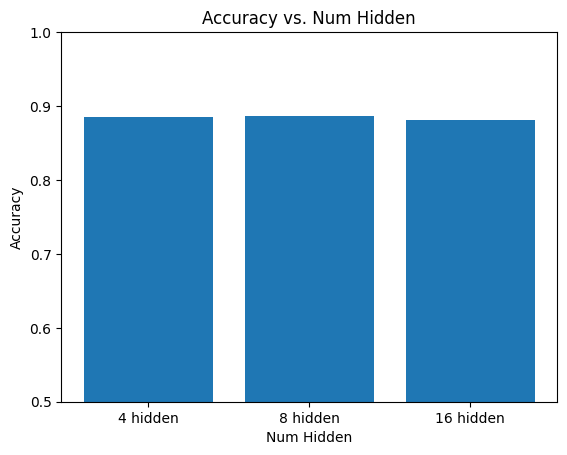

In [66]:
plt.title("Accuracy vs. Num Hidden")
plt.xlabel("Num Hidden")
plt.ylabel("Accuracy")
plt.bar(accs.keys(), accs.values())
plt.ylim(.5, 1)
plt.savefig("hidden.png")
plt.show()